# Introduction: Particle Swarm Regression

In this notebook we will walk through how to use [Particle Swarm Optimisation](https://en.wikipedia.org/wiki/Particle_swarm_optimization)  to produce optimal Linear Regression models for a range of custom loss metrics. Using a methodology introduced by [Dietterich (1998)](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf) we will perform a siginificance test on the holdout predictions, to see whether training on custom loss metrics produces significantly better models.

## Model Error

In regression problems the target variable is continuous and our model can make errors in two ways
1. Underpredict the target
2. Overpredict the target

The Ordinary Least Squares and Gradient Descent implementations of Linear Regression both minmise Mean Squared Error as the loss function. Mean Square error places equal importance on an underprediction vs an overprediction. However in practice our preferences for both types of error are rarely the same instead they are driven by the business problem at hand. For example to improve efficiency a utility company might want to know how much electricity they can put through a [transformer](https://en.wikipedia.org/wiki/Transformer) without it overheating. For this use case an overprediction would mean a loss of efficiency, but an underprediction could lead to a failure of the transformer, blackouts for customers and heavy regulatory fines.

One solution to this problem is to add on "safety" margins to our predictions. However a more elegant approach is to encode our preferences directly in a function which we use directly to optimise our model coefficients.

## Particle Swarm Optimisation
Particle swarm optimization (PSO) is a computational method that optimizes a problem by iteratively trying to improve a candidate solution with regard to a given measure of quality. It solves a problem by having a population of candidate solutions, here dubbed particles, and moving these particles around in the search-space according to simple mathematical formulae over the particle's position and velocity. Each particle's movement is influenced by its local best known position, but is also guided toward the best known positions in the search-space, which are updated as better positions are found by other particles. This is expected to move the swarm toward the best solutions.

I have [coded up an implementation](https://github.com/tonyjward/machine-learning-oop/blob/master/twlearn/ParticleSwarm.py) of PSO based on the above Wiki page which i'll use to produce throughout this notebook.


In [1]:
# Numpy for data manipulation
import numpy as np
import pandas as pd

# Modelling
from twlearn import LinearRegression

# Evaluation of the model
import sklearn.model_selection
NO_FOLDS = 2
NO_REPEATS = 5

## Data
For this notebook we will work with the [Boston Housing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) available as part of scikit learn. The objective is to predict the Median value of owner-occupied homes by training a model on past data. This is a supervised machine learning regression task: given past data we want to train a model to predict a continous outcome on testing data.

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

X = np.array(boston.data)
Y = np.array(boston.target)

# split the data into training and testing
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33, random_state = 1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (339, 13)
X_test shape: (167, 13)


## Ordinary Least Squares

First lets train an ordinary least squares regression model and examine a residuals (defined as actual - predicted) vs predicted plot

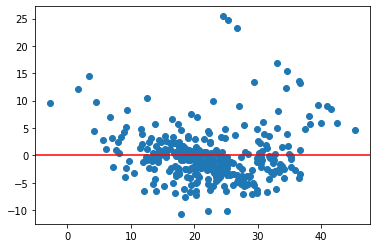

In [3]:
import matplotlib.pyplot as plt 

# train model
OLS_model = LinearRegression()
OLS_model.fit(X_train, Y_train, optimiser = 'OLS')

# examine predicted vs residuals
def residual_scatter_plot(predicted, actual):
    if len(predicted.shape) == 1:
        predicted = predicted.reshape(-1,1)
    if len(actual.shape) == 1:
        actual = actual.reshape(-1, 1)
    
    error = actual - predicted
    
    plt.scatter(predicted, error)
    plt.axhline(color='r')
    
residual_scatter_plot(predicted = OLS_model.predict(X_train),
                      actual    = Y_train)

There is a definite upside down U patturn in the residuals. This indicates that the relationship between the input variables and the target is not linear, which is a required assumption of Linear Regression. Lets instead take logs of the target variable and re-run the model.

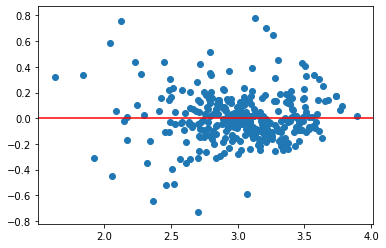

In [9]:
# Transform target
log_Y_train = np.log(Y_train)

# Train model
log_OLS_model = LinearRegression()
log_OLS_model.fit(X_train, 
                  log_Y_train, 
                  optimiser = 'OLS')

# Examine predicted vs residuals
residual_scatter_plot(predicted = log_OLS_model.predict(X_train),
                      actual    = log_Y_train)

That has removed the U shaped pattern in the residuals. If we look at the spread of residuals from left to right the variance appears to reduce which means we can't assume Homoscedasticity of errors. This invalidates any siginificance tests done on the resulting model coefficients. However we won't be performing variable selection in this notebook. Rather we will be focusing on the underlying loss functions and optimisation procedures, therefore I'm happy to proceed without worrying about this.

## Particle Swarm Regression

Before we can perform particle swarm regression we need to construct a loss function. Details of the required input and output dimensions are provided in the doc string

In [10]:
def Rmse(predictions, actual):
    """
   Calculate Root mean square error

    Arguments:
        predictions: predictions numpy array of size (no_examples, no_solutions)
        actuals: 1D numpy array of size (no_examples, 1)

    Returns:
        rmse: rmse for each solution - numpy array of size (1, no_solutions)
    
    Approach:
    predictions can be a 1d array which corresponds to one set of model predictions OR
    if can be a matrix of predictions, where each column represents a set of predictions
    for a specific model (which is usefule for particle swarm optimisation)
    """
    assert(predictions.shape[0] == actual.shape[0])
    if len(predictions.shape) == 1:
        predictions = predictions.reshape(-1, 1)
    if len(actual.shape) == 1:
        actual = actual.reshape(-1, 1)
   
    no_examples, no_solutions = predictions.shape

    squared_error = np.square(predictions - actual)
    assert(squared_error.shape == predictions.shape)

    sum_of_squares = np.sum(squared_error, axis = 0, keepdims = True)
    assert(sum_of_squares.shape == (1, no_solutions))
    
    rmse = np.sqrt(sum_of_squares)
    assert(rmse.shape == (1, no_solutions))

    return rmse

Before proceeding we must test out function works as expected.

In [11]:
import unittest

class Test_1_solution(unittest.TestCase):
    """ Test covers predictions argument containing one set of solutions"""
    def setUp(self):
        self.predictions = np.array([1, 2, 3])
        self.actuals = np.array([0.9, 2.2, 2.7])

    def test_Rmse(self):
        rmse = Rmse(self.predictions, self.actuals)
        self.assertIsNone(np.testing.assert_allclose(rmse, 0.374165739))

class Test_2_solutions(unittest.TestCase):
    """ Test covers predictions argument containing two set of solutions"""
    def setUp(self):
        self.predictions = np.array([[1,1], [2, 2], [3, 3]])
        self.actuals = np.array([0.9, 2.2, 2.7])

    def test_Rmse(self):
        rmse = Rmse(self.predictions, self.actuals)
        self.assertIsNone(np.testing.assert_allclose(rmse, np.array([[0.374165739, 0.374165739]])))
        
# run tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


Now lets train the model using our Rmse loss function, and compare the model coeffecients to the ordinary least square implementation. For brevity i'm going to retrain the OLS model and remove the log prefix 

In [12]:
# Train Ordinary Least Squares
OLS = LinearRegression()
OLS.fit(X_train, 
        log_Y_train, 
        optimiser = 'OLS')

# Train Particle Swarm Regression using Rmse
PSO_Rmse = LinearRegression()
PSO_Rmse.fit(X_train, log_Y_train, optimiser = 'PSO', loss = Rmse)

# Compare model coefficients
print("Compare model coefficients")
OLS_coef = OLS.coefficients()['coefficients']
PSO_Rmse_coef = PSO_Rmse.coefficients()['coefficients']
print(np.c_[OLS_coef, PSO_Rmse_coef])

[[-1.23746674e-02 -1.11522059e-02]
 [ 1.66421669e-03  3.60249098e-04]
 [ 3.72580218e-03  2.94792996e-03]
 [ 1.13767502e-01  1.48240367e-01]
 [-9.60027507e-01 -7.83394304e-01]
 [ 7.33257927e-02  1.34872604e-01]
 [ 3.63675693e-04 -1.44650159e-04]
 [-4.91654305e-02 -3.53466834e-02]
 [ 1.57791797e-02  1.01138593e-02]
 [-5.57481334e-04 -3.11852507e-04]
 [-4.17978601e-02 -3.68735098e-02]
 [ 2.64662123e-04  3.69682640e-04]
 [-2.80645306e-02 -2.33758474e-02]]


Model coefficients are close but not exactly the same. Ordinary Least Squares finds the coefficients using a closed form solution we know that is must give the model coefficients that minimise RMSE on the training data. Lets double check that is the case using a helper function

In [13]:
def evaluate(model, X, Y, loss):
    """ Take a model and and some test data and produce test metrics
    Arguments:
        model         -- a fitted model
        X_test        -- test data - a numpy array
        loss_function -- a loss function to assess predictions

    Returns:
        loss - calculated loss
    """
    predictions = model.predict(X)
    return loss(predictions, Y)

# compare models using Rmse
print(f"OLS has a training Rmse of: {evaluate(OLS, X_train, log_Y_train, Rmse)}")
print(f"PSO has a training Rmse of: {evaluate(PSO_Rmse, X_train, log_Y_train, Rmse)}")

OLS has a training Rmse of: [[3.53432877]]
PSO has a training Rmse of: [[3.59868801]]


Lets increase the number of iterations and particles from their defaults of 500 and 300 respectively to see if we can get closer to the "true" coefficient values.

In [16]:
# Train Particle Swarm Regression using Rmse and refined hyperparameters
PSO_Rmse = LinearRegression()
PSO_Rmse.fit(X_train, log_Y_train, optimiser = 'PSO', loss = Rmse, num_iterations = 5000, no_particles = 500)

# Compare model coefficients
print("Compare model coefficients")
PSO_Rmse_coef = PSO_Rmse.coefficients()['coefficients']
print(np.c_[OLS_coef, PSO_Rmse_coef])
print("\n")

# Compare model training error using Rmse
print(f"OLS has a training Rmse of: {evaluate(OLS, X_train, log_Y_train, Rmse)}")
print(f"PSO has a training Rmse of: {evaluate(PSO_Rmse, X_train, log_Y_train, Rmse)}")

Compare model coefficients
[[-1.23746674e-02 -1.23744075e-02]
 [ 1.66421669e-03  1.66401162e-03]
 [ 3.72580218e-03  3.72440898e-03]
 [ 1.13767502e-01  1.13777783e-01]
 [-9.60027507e-01 -9.59848486e-01]
 [ 7.33257927e-02  7.33403189e-02]
 [ 3.63675693e-04  3.63446679e-04]
 [-4.91654305e-02 -4.91611845e-02]
 [ 1.57791797e-02  1.57775666e-02]
 [-5.57481334e-04 -5.57423014e-04]
 [-4.17978601e-02 -4.17944988e-02]
 [ 2.64662123e-04  2.64655779e-04]
 [-2.80645306e-02 -2.80637691e-02]]


OLS has a training Rmse of: [[3.53432877]]
PSO has a training Rmse of: [[3.53432878]]


# Optimising Mean Absolute Error 
Now we have established that particle swarm can succssfully optimise Rmse lets try Mean Absolute Error. 

In [18]:
from twlearn.metrics import Mae

In [22]:
# Train Particle Swarm Regression using Mae and refined hyperparameters
PSO_Mae = LinearRegression()
PSO_Mae.fit(X_train, log_Y_train, optimiser = 'PSO', loss = Mae, num_iterations = 5000, no_particles = 500)

# Compare model training error using Mae
print(f"OLS has a training Mae of: {evaluate(OLS, X_train, log_Y_train, Mae)}")
print(f"PSO has a training Mae of: {evaluate(PSO_Mae, X_train, log_Y_train, Mae)}")


OLS has a training Mae of: [[0.13633392]]
PSO has a training Mae of: [[0.12874746]]


Great so we have established that we can minimise a custom loss function on the training data. However what we really care about is the generalisation error of the model. Lets see how both models perform on the test set with respect to Mae.

In [24]:
# Compare model test error using Mae
log_Y_test = np.log(Y_test)
print(f"OLS has a test Mae of: {evaluate(OLS, X_test, log_Y_test, Mae)}")
print(f"PSO has a test Mae of: {evaluate(PSO_Mae, X_test, log_Y_test, Mae)}")

OLS has a test Mae of: [[0.13851069]]
PSO has a test Mae of: [[0.13117901]]


Cool! As we had hoped the particle swarm model trained on Mae performs better than the Ordinary Least square model on test data when evaluated using Mae. For curiosity lets just see how well the PSO_Mae model performs with respect to Rmse

In [25]:
# Compare model test error using Rmse
log_Y_test = np.log(Y_test)
print(f"OLS has a test Rmse of: {evaluate(OLS, X_test, log_Y_test, Rmse)}")
print(f"PSO has a test Rmse of: {evaluate(PSO_Mae, X_test, log_Y_test, Rmse)}")

OLS has a test Rmse of: [[2.38162665]]
PSO has a test Rmse of: [[2.42202405]]


In this case the OLS model outperforms the Pso_Mae model which we would expect, unless there were serious outliers present in the data.


# Optimising Fourth Quadrant Error
Now lets imagine a scenario where we don't have equal preference for an under/over prediction. Lets say we really don't want to underpredict when the target variable is higher than the mean value. More formally we want to treat errors in the fourth quadrant as 100 more costly as those elsewhere.


In [35]:
def fourth_quadrant(predictions, actual, multiplier = 100):
    """
    Calculate Mean Absolute Error

    Arguments:
        predictions: predictions numpy array of size (no_examples, no_particles)
        actuals: 1D numpy array of size (no_examples, 1)
        multiplier: int - how much weight to give underpredictions for positive actual values

    Returns:
        mae: mae for each particle - numpy array of size (1, no_particles)
    """
    assert(predictions.shape[0] == actual.shape[0])

    if len(predictions.shape) == 1:
        predictions = predictions.reshape(-1, 1)
    if len(actual.shape) == 1:
        actual = actual.reshape(-1, 1)
     
    errors = actual - predictions
    assert(errors.shape == predictions.shape)
 
    negative_error_index = errors < 0
    positive_actual_index = actual > np.mean(actual)

    extra_weight_index = np.logical_and(negative_error_index, positive_actual_index)

    # cautious adjustment
    adjustment = np.ones(shape = errors.shape)
    adjustment[extra_weight_index] = multiplier

    # squared error with adjustment
    adjusted_squared_error = np.multiply(np.square(errors), adjustment)

    return np.mean(adjusted_squared_error, axis = 0, keepdims = True)

In [36]:
# Train Particle Swarm Regression using fourth_quadrant
PSO_4Q = LinearRegression()
PSO_4Q.fit(X_train, log_Y_train, optimiser = 'PSO', loss = fourth_quadrant, num_iterations = 5000, no_particles = 500)

# Compare model test error using fourth_quadrant
print(f"OLS has a test fourth_quadrant error of: {evaluate(OLS, X_test, log_Y_test, fourth_quadrant)}")
print(f"PSO has a test fourth_quadrant error of: {evaluate(PSO_4Q, X_test, log_Y_test, fourth_quadrant)}")

OLS has a test fourth_quadrant error of: [[0.52487216]]
PSO has a test fourth_quadrant error of: [[0.17752881]]


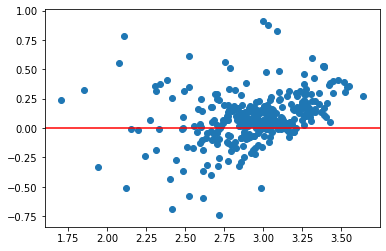

In [38]:
# PSO Model trained on fourth quadrant
residual_scatter_plot(predicted = PSO_4Q.predict(X_train),
                      actual    = log_Y_train)

We see that compared to the chart below, the model trained on fourth quadrant error makes less errors in the fourth quadrant.

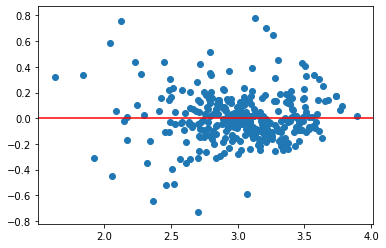

In [39]:
# Ordinary Least Squares
residual_scatter_plot(predicted = OLS.predict(X_train),
                      actual    = log_Y_train)

## Is this significant?
The boston housing dataset is quite small with only 519 data points. We would like a methodology for assessing the significance of our findings. Our first thought might be to do 10-fold cross validation, and compare the performance between both algorithms on each fold using a students paired t test. However this would be incorrect, since one of the core assumptions (independence) of the t test would be violated. 

[Machine Learning Mastery](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/) explain more about the pitfalls of performing significance testing on cross validaiton data. The author introduces us to Perhaps the seminal work on this topic -  the 1998 paper titled “Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms” by Thomas Dietterich.[Dietterich (1998)](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf)

Dietterich recommends a resampling method of his own devising called 5×2 cross-validation that involves 5 repeats of 2-fold cross-validation. Two folds are chosen to ensure that each observation appears only in the train or test dataset for a single estimate of model skill. A paired Student’s t-test is used on the results, updated to better reflect the limited degrees of freedom given the dependence between the estimated skill scores.

In [40]:
def cross_validate(no_repeats, no_folds, loss, kwargs):
    """
    Approach:
        We want the random numbers for repeat 1 to be different for repeat 2, etc
        however we also want the random numbers for repeat 1, to be the same
        each time we run the cross_validation to ensure we can compare algorithm
        performance. We therefore set the seed to be the repeat number.
    """  
    boston = load_boston()

    X = np.array(boston.data)
    Y = np.log(np.array(boston.target))

    no_examples, no_features = X.shape

    cv_results = {}

    for repeat in range(NO_REPEATS):
        print(f"repeat: {repeat}")
        
        np.random.seed(repeat)
        folds = np.random.randint(low = 0, high = NO_FOLDS , size = no_examples)
        
        cv_results[repeat] = {}
  
        for fold in range(NO_FOLDS):
            print(f"fold: {fold}")

            X_train = X[folds != fold,:]
            X_test  = X[folds == fold,:]
            Y_train = Y[folds != fold]
            Y_test  = Y[folds == fold]           

            # train model
            model = LinearRegression()
            model.fit(X_train, Y_train, **kwargs)

            # evaluate model
            cv_results[repeat][fold] = evaluate(model, X_test, Y_test, loss)

    return cv_results

Train models 

In [41]:
CUSTOM_LOSS = Mae

print("\t Training OLS Model")
ols_results_mae = cross_validate(no_repeats = NO_REPEATS, no_folds = NO_FOLDS, loss = CUSTOM_LOSS, 
                             kwargs = {"optimiser":"OLS"})

print("\t Training PSO Model")
pso_results_mae = cross_validate(no_repeats = NO_REPEATS, no_folds = NO_FOLDS, loss = CUSTOM_LOSS,
                             kwargs = {"optimiser":'PSO', "loss":CUSTOM_LOSS, "num_iterations":5000, "no_particles":500})

	 Training OLS Model
repeat: 0
fold: 0
fold: 1
repeat: 1
fold: 0
fold: 1
repeat: 2
fold: 0
fold: 1
repeat: 3
fold: 0
fold: 1
repeat: 4
fold: 0
fold: 1
	 Training PSO Model
repeat: 0
fold: 0
fold: 1
repeat: 1
fold: 0
fold: 1
repeat: 2
fold: 0
fold: 1
repeat: 3
fold: 0
fold: 1
repeat: 4
fold: 0
fold: 1


In [42]:
print("Comparing Models using Mean Absolute Error")
for repeat in range(NO_REPEATS):
    for fold in range(NO_FOLDS):
        print(f"Error for repeat {repeat} fold {fold}: OLS: {np.round(ols_results_mae[repeat][fold],4)} PSO: {np.round(pso_results_mae[repeat][fold],4)} difference : {np.round(ols_results_mae[repeat][fold] - pso_results_mae[repeat][fold],4)}")

Comparing Models using Mean Absolute Error
Error for repeat 0 fold 0: OLS: [[0.1355]] PSO: [[0.1313]] difference : [[0.0042]]
Error for repeat 0 fold 1: OLS: [[0.144]] PSO: [[0.1408]] difference : [[0.0032]]
Error for repeat 1 fold 0: OLS: [[0.1489]] PSO: [[0.1519]] difference : [[-0.003]]
Error for repeat 1 fold 1: OLS: [[0.1391]] PSO: [[0.1337]] difference : [[0.0054]]
Error for repeat 2 fold 0: OLS: [[0.1414]] PSO: [[0.1314]] difference : [[0.01]]
Error for repeat 2 fold 1: OLS: [[0.1436]] PSO: [[0.1432]] difference : [[0.0004]]
Error for repeat 3 fold 0: OLS: [[0.1331]] PSO: [[0.128]] difference : [[0.0051]]
Error for repeat 3 fold 1: OLS: [[0.1524]] PSO: [[0.1456]] difference : [[0.0068]]
Error for repeat 4 fold 0: OLS: [[0.134]] PSO: [[0.1346]] difference : [[-0.0006]]
Error for repeat 4 fold 1: OLS: [[0.143]] PSO: [[0.1423]] difference : [[0.0007]]


In [43]:
from twlearn.statistics import five_by_two_cv, p_value

t_statistic, average_differences = five_by_two_cv(ols_results_mae, pso_results_mae)

for repeat in average_differences:
    print(f"Average difference for repeat {repeat}: {np.round(average_differences[repeat],4)}")

p = p_value(t_statistic = t_statistic,
            degrees_freedom = 5,
            sided = 2)
print(f"\n The t statistic is {np.round(t_statistic,2)} which has a p value of {p}")

Average difference for repeat 0: [[0.0037]]
Average difference for repeat 1: [[0.0012]]
Average difference for repeat 2: [[0.0052]]
Average difference for repeat 3: [[0.006]]
Average difference for repeat 4: [[0.]]

 The t statistic is [[1.03]] which has a p value of [[0.35072015]]


The p-value associate with this test is not significant at the 5% level, so we find no evidence to reject the null hypothesis that there is no difference between the models.


# Fourth Quadrant Errors

Lets have a look at the distribution of error vs actual values. What if we really didn't want to underpredict at the high actual values? <insert image>

In [44]:
CUSTOM_LOSS = fourth_quadrant

print("Training OLS Model")
ols_results_4Q = cross_validate(no_repeats = NO_REPEATS, no_folds = NO_FOLDS, loss = CUSTOM_LOSS, 
                             kwargs = {"optimiser":"OLS"})

print("Training PSO Model")
pso_results_4Q = cross_validate(no_repeats = NO_REPEATS, no_folds = NO_FOLDS, loss = CUSTOM_LOSS,
                             kwargs = {"optimiser":'PSO', "loss":CUSTOM_LOSS, "num_iterations":5000, "no_particles":500})

Training OLS Model
repeat: 0
fold: 0
fold: 1
repeat: 1
fold: 0
fold: 1
repeat: 2
fold: 0
fold: 1
repeat: 3
fold: 0
fold: 1
repeat: 4
fold: 0
fold: 1
Training PSO Model
repeat: 0
fold: 0
fold: 1
repeat: 1
fold: 0
fold: 1
repeat: 2
fold: 0
fold: 1
repeat: 3
fold: 0
fold: 1
repeat: 4
fold: 0
fold: 1


In [45]:
print("Comparing Models using Fourth Quadrant Error")
for repeat in range(NO_REPEATS):
    for fold in range(NO_FOLDS):
        print(f"Error for repeat {repeat} fold {fold}: OLS: {np.round(ols_results_4Q[repeat][fold],2)} PSO: {np.round(pso_results_4Q[repeat][fold],2)} difference : {np.round(ols_results_4Q[repeat][fold] - pso_results_4Q[repeat][fold],2)}")

Comparing Models using Fourth Quadrant Error
Error for repeat 0 fold 0: OLS: [[0.52]] PSO: [[0.14]] difference : [[0.38]]
Error for repeat 0 fold 1: OLS: [[0.44]] PSO: [[0.07]] difference : [[0.37]]
Error for repeat 1 fold 0: OLS: [[0.2]] PSO: [[0.08]] difference : [[0.12]]
Error for repeat 1 fold 1: OLS: [[0.69]] PSO: [[0.16]] difference : [[0.53]]
Error for repeat 2 fold 0: OLS: [[0.45]] PSO: [[0.07]] difference : [[0.38]]
Error for repeat 2 fold 1: OLS: [[0.44]] PSO: [[0.14]] difference : [[0.29]]
Error for repeat 3 fold 0: OLS: [[0.58]] PSO: [[0.15]] difference : [[0.43]]
Error for repeat 3 fold 1: OLS: [[0.29]] PSO: [[0.08]] difference : [[0.21]]
Error for repeat 4 fold 0: OLS: [[0.51]] PSO: [[0.14]] difference : [[0.37]]
Error for repeat 4 fold 1: OLS: [[0.31]] PSO: [[0.08]] difference : [[0.24]]


In [46]:
t_statistic, average_differences = five_by_two_cv(ols_results_4Q, pso_results_4Q)

for repeat in average_differences:
    print(f"Average difference for repeat {repeat}: {np.round(average_differences[repeat],4)}")

p = p_value(t_statistic = t_statistic,
            degrees_freedom = 5,
            sided = 2)

print(f"\n The t statistic is {np.round(t_statistic,2)} which has a p value of {p}")

Average difference for repeat 0: [[0.3762]]
Average difference for repeat 1: [[0.3281]]
Average difference for repeat 2: [[0.3376]]
Average difference for repeat 3: [[0.3231]]
Average difference for repeat 4: [[0.3033]]

 The t statistic is [[2.47]] which has a p value of [[0.05639101]]


The p value associated with this test is 0.056 which is in the grey area of betwen 5% and 10% significance level. Therefore we conclude that there is weak evidence that the model trained on fourth quadrant error performs better than ordinary least squares with respect to fourth quadrant error